# Deep Neural Network - Cat Image Classifier

This neural network is my first partial implementation from the Andrew Ng Deep Learning assignment in the Deep Learing specialization course.  The neural network classifies images as cat images or non-cat images.  The images come from the Andrew Ng course as well. This document is not meant to be read from top to bottom.  It's best to start at [L-Layer-Model Section](#L-Layer-Model).  Follow the algorithm and then read the [helper functions](#Helper-Functions) as you encounter them.  For most parts of this algorithm, I will write up another notebook going in-depth about the subject to provide a comprehenive understanding intuition.

## Import Pacakages and Set Defaults

First let's import some packages that the algorithm will need and set some constants
 - [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
 - [time](https://docs.python.org/3/library/time.html) provides various time-related functions.
 - [h5pyp](https://www.h5py.org/) is a Pythonic interface to the [HDF5](https://www.hdfgroup.org/) binary data format. The format can be found [here](https://www.hdfgroup.org/solutions/hdf5/).
 - [matplotlib](http://matplotlib.org) is a library for plotting graphs in Python.
 - [scipy](https://www.scipy.org/) is a Python-based ecosystem of open-source software for mathematics, science, and engineering.
 - [PIL](https://pillow.readthedocs.io/en/stable/) is the Python Imaging Library.

In [2]:
import numpy as np
import time
import h5py
import matplotlib.pyplot as plt

import scipy
from PIL import Image
from scipy import ndimage

Set defaults and constants
 - `%matplotlib inline` A magic function in Python.  This line sets [matplotlib backend](https://matplotlib.org/faq/usage_faq.html#what-is-a-backend) to inline.  With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it.
 - `plt.rcParams` Used to set matplotlib default values<br>
   `plt.rcParams['figure.figsize'] = (5.0, 4.0)` sets the default size of the plots. (width, height) in inches.<br>
   `plt.rcParams['image.interpolation'] = 'nearest'` sets the image interpolation to nearest. During scaling we want the pixels to be rendered accurately
   `plt.rcParams['image.cmap'] = 'gray'` sets the colormap to gray. [colormap](https://matplotlib.org/gallery/color/colormap_reference.html)

In [4]:
# Set the matplotlib backend
%matplotlib inline

# Set default plot parameters
plt.rcParams['figure.figsize'] = (5.0, 4.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ensure we get the same random numbers each time by using a constant seed value. (for debugging purposes only)
np.random.seed(1)

# Define the number of layers and the nodes of each layer 
layers_dims = [12288, 20, 7, 5, 1] #  4-layer model

## Helper Functions

### Load Data
The `load_data()` method loads training and test datasets that contain images and labels that indicate whether each picture is a cat or non-cat.  The file format used is an [HDF5 (.h5 extention)](https://portal.hdfgroup.org/display/HDF5/File+Format+Specification).

 - `train_dataset` is the training set
 - `train_set_x_orig` is the training images
 - `train_set_y_orig` is the training image labels
 - `test_dataset` is the test set
 - `test_set_x_orig` is the test images
 - `test_set_y_orig` is the test image labels
 - `classes` is the list of classes to represent cat or non-cat

In [22]:
def load_data():
    # Read training set
    train_dataset = h5py.File('D:/Datasets/train_catvnoncat.h5', "r")
    # Get training set features
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    # Get training set labels
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    # Read test set
    test_dataset = h5py.File('D:/Datasets/test_catvnoncat.h5', "r")
    # Get test set features
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    # Get test set labels
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])

    # Get the list of classes
    classes = np.array(test_dataset["list_classes"][:])

    # Turns rank 1 arrays to rank 2 arrays, i.e. array with shape (n,) to (1,n)
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

### Sigmoid Activation

The `sigmoid()` function implements the sigmoid mathematical function, $h(z)=\dfrac{1}{1+e^{-z}}$.

I've created another notebook called [Activation Functions](ActivationFunctions.ipynb) that details some common activation functions and when to use them.

In [3]:
# Implements the sigmoid activation in numpy
#
# Arguments:
#    Z -- numpy array of any shape
#
# Returns:
#    A -- output of sigmoid(z), same shape as Z
#    cache -- returns Z as well, useful during backpropagation
def sigmoid(Z):
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

### Sigmoid Backwards Activation

In [4]:
# Implement the backward propagation for a single SIGMOID unit.
#
# Arguments:
#    dA -- post-activation gradient, of any shape
#    cache -- 'Z' where we store for computing backward propagation efficiently
#
# Returns:
#    dZ -- Gradient of the cost with respect to Z
def sigmoid_backward(dA, cache):
    Z = cache
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### ReLU Activation Function

The `sigmoid()` function implements the sigmoid mathematical function, $h(z)=\dfrac{1}{1+e^{-z}}$.

I've created another notebook called [Activation Functions](ActivationFunctions.ipynb) that details some common activation functions and when to use them.

In [5]:
# Implement the RELU function.
#
# Arguments:
#    Z -- Output of the linear layer, of any shape
#
# Returns:
#    A -- Post-activation parameter, of the same shape as Z
#    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
def relu(Z):
    A = np.maximum(0,Z)
    assert(A.shape == Z.shape)
    cache = Z 

    return A, cache

### ReLU Backwards Activation

In [6]:
# Implement the backward propagation for a single RELU unit.
#
# Arguments:
#    dA -- post-activation gradient, of any shape
#    cache -- 'Z' where we store for computing backward propagation efficiently
#
# Returns:
#    dZ -- Gradient of the cost with respect to Z
def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.

    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    assert (dZ.shape == Z.shape)
    
    return dZ

### Predict

In [7]:
# This function is used to predict the results of a  L-layer neural network.
#    
# Arguments:
#    X -- data set of examples you would like to label
#    parameters -- parameters of the trained model
#    
# Returns:
#    p -- predictions for the given dataset X
def predict(X, y, parameters):
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to 0/1 predictions
    for i in range(0, probas.shape[1]):
        if probas[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0
    
    #print results
    #print ("predictions: " + str(p))
    #print ("true labels: " + str(y))
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

### Print Mismatched Pictures

In [8]:
# Plots images where predictions and truth were different.
#    X -- dataset
#    y -- true labels
#    p -- predictions
def print_mislabeled_images(classes, X, y, p):
    a = p + y
    mislabeled_indices = np.asarray(np.where(a == 1))
    plt.rcParams['figure.figsize'] = (40.0, 40.0) # set default size of plots
    num_images = len(mislabeled_indices[0])
    for i in range(num_images):
        index = mislabeled_indices[1][i]
        
        plt.subplot(2, num_images, i + 1)
        plt.imshow(X[:,index].reshape(64,64,3), interpolation='nearest')
        plt.axis('off')
        plt.title("Prediction: " + classes[int(p[0,index])].decode("utf-8") + " \n Class: " + classes[y[0,index]].decode("utf-8"))

## Initialize Parameters

In [9]:
# Arguments:
#    layer_dims -- python array (list) containing the dimensions of each layer in our network
#    
# Returns:
#    parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
#    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
#    bl -- bias vector of shape (layer_dims[l], 1)
def initialize_parameters_deep(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## Linear-Forward

In [10]:
# Implement the linear part of a layer's forward propagation.
#
# Arguments:
#    A -- activations from previous layer (or input data): (size of previous layer, number of examples)
#    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
#    b -- bias vector, numpy array of shape (size of the current layer, 1)
#
# Returns:
#    Z -- the input of the activation function, also called pre-activation parameter 
#    cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
def linear_forward(A, W, b):
    Z = np.dot(W, A) + b
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

## Linear-Activation-Forward

In [11]:
# Implement the forward propagation for the LINEAR->ACTIVATION layer
#
# Arguments:
#    A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
#    W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
#    b -- bias vector, numpy array of shape (size of the current layer, 1)
#    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
#
# Returns:
#    A -- the output of the activation function, also called the post-activation value 
#    cache -- a python dictionary containing "linear_cache" and "activation_cache";
#             stored for computing the backward pass efficiently
def linear_activation_forward(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)

    return A, cache

## L_Model_Forward

In [12]:
# Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
#    
# Arguments:
#    X -- data, numpy array of shape (input size, number of examples)
#    parameters -- output of initialize_parameters_deep()
#    
# Returns:
#    AL -- last post-activation value
#    caches -- list of caches containing:
#                every cache of linear_activation_forward() (there are L-1 of them, indexed from 0 to L-1)
def L_model_forward(X, parameters):
    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    caches.append(cache)
    
    assert(AL.shape == (1,X.shape[1]))
            
    return AL, caches

## Cost Function

In [13]:
# Implement the cost function defined by equation (7).
#
# Arguments:
#    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
#    Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)
#
# Returns:
#    cost -- cross-entropy cost
def compute_cost(AL, Y):
    m = Y.shape[1]
    cost = (-1/m) * np.sum(np.dot(Y, np.log(AL).T) + np.dot(1-Y, np.log(1-AL).T))
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    assert(cost.shape == ())
    
    return cost

## Linear-Backward

In [14]:
# Implement the linear portion of backward propagation for a single layer (layer l)
#
# Arguments:
#    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
#    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer
#
# Returns:
#    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
#    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
#    db -- Gradient of the cost with respect to b (current layer l), same shape as b
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m)*np.dot(dZ, A_prev.T)
    db = (1/m)*np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

## Linear-Activation-Backward

In [15]:
# Implement the backward propagation for the LINEAR->ACTIVATION layer.
#  
# Arguments:
#    dA -- post-activation gradient for current layer l 
#    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
#    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
#    
# Returns:
#    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
#    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
#    db -- Gradient of the cost with respect to b (current layer l), same shape as b
def linear_activation_backward(dA, cache, activation):
    linear_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

## L-Model-Backwards

In [16]:
# Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
#    
# Arguments:
#    AL -- probability vector, output of the forward propagation (L_model_forward())
#    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
#    caches -- list of caches containing:
#                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
#                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
#    
# Returns:
#    grads -- A dictionary with the gradients
#             grads["dA" + str(l)] = ... 
#             grads["dW" + str(l)] = ...
#             grads["db" + str(l)] = ... 
def L_model_backward(AL, Y, caches):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    # Initializing the backpropagation
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    
    # Lth layer (SIGMOID -> LINEAR) gradients.
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, "sigmoid")

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, "relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

## Update Parameters

In [17]:
# Update parameters using gradient descent
#    
# Arguments:
#    parameters -- python dictionary containing your parameters 
#    grads -- python dictionary containing your gradients, output of L_model_backward
#    
# Returns:
#    parameters -- python dictionary containing your updated parameters 
#                  parameters["W" + str(l)] = ... 
#                  parameters["b" + str(l)] = ...
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]

    return parameters

## L-Layer-Model

In [18]:
# Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
#    
# Arguments:
#    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
#    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
#    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
#    learning_rate -- learning rate of the gradient descent update rule
#    num_iterations -- number of iterations of the optimization loop
#    print_cost -- if True, it prints the cost every 100 steps
#    
# Returns:
#    parameters -- parameters learnt by the model. They can then be used to predict.
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization. (≈ 1 line of code)
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every 100 training example
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

### Load Training and Test Data

In [18]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

### Exploratory Data Analysis

In [21]:
# Explore your dataset 
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))
print ("classes shape: " + str(classes.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)
classes shape: (2,)


### Reshape Data

In [21]:
# Reshape the training and test examples 
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # The "-1" makes reshape flatten the remaining dimensions
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Standardize data to have feature values between 0 and 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


## Train the Model

Cost after iteration 0: 0.693148
Cost after iteration 100: 0.678011
Cost after iteration 200: 0.667600
Cost after iteration 300: 0.660422
Cost after iteration 400: 0.655458
Cost after iteration 500: 0.652013
Cost after iteration 600: 0.649616
Cost after iteration 700: 0.647942
Cost after iteration 800: 0.646770
Cost after iteration 900: 0.645947
Cost after iteration 1000: 0.645368
Cost after iteration 1100: 0.644961
Cost after iteration 1200: 0.644673
Cost after iteration 1300: 0.644469
Cost after iteration 1400: 0.644325
Cost after iteration 1500: 0.644223
Cost after iteration 1600: 0.644151
Cost after iteration 1700: 0.644100
Cost after iteration 1800: 0.644063
Cost after iteration 1900: 0.644037
Cost after iteration 2000: 0.644019
Cost after iteration 2100: 0.644006
Cost after iteration 2200: 0.643997
Cost after iteration 2300: 0.643990
Cost after iteration 2400: 0.643985


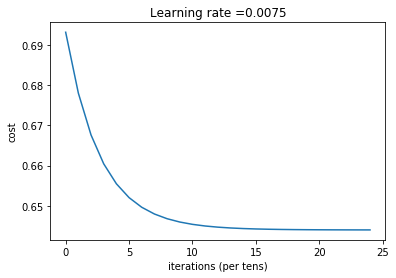

In [22]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

## Accuracy on Training Data

In [23]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.6555023923444976


## Accuracy on Test Data

In [24]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.3400000000000001


## Mislabeled Pictures

In [1]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

NameError: name 'print_mislabeled_images' is not defined